In [1]:
!pip install folium

In [2]:
!pip install geopy

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from IPython.display import display, HTML, IFrame
import folium
from folium.plugins import MarkerCluster
import time
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Task1
#Load Datasets
zomato_df = pd.read_csv('/content/zomato_data.csv')
geo_df = pd.read_csv('/content/Geographical Coordinates.csv')

#Initial Check
print("Initial Shape:", zomato_df.shape)
print(zomato_df.info())
print(zomato_df.isnull().sum())

#Clean 'rate' column
zomato_df['rate'] = zomato_df['rate'].replace('-', np.nan)
zomato_df['rate'] = zomato_df['rate'].str.replace('/5', '', regex=False)
zomato_df['rate'] = pd.to_numeric(zomato_df['rate'], errors='coerce')
zomato_df['rate'].fillna(zomato_df['rate'].median(), inplace=True)
print(zomato_df['rate'].describe())
print(zomato_df['rate'].isnull().sum())

#Clean 'approx_costfor_two_people'
zomato_df['approx_costfor_two_people'] = zomato_df['approx_costfor_two_people'].astype(str).str.replace(',', '', regex=False)
zomato_df['approx_costfor_two_people'] = pd.to_numeric(zomato_df['approx_costfor_two_people'], errors='coerce')
zomato_df['approx_costfor_two_people'].fillna(zomato_df['approx_costfor_two_people'].median(), inplace=True)
print(zomato_df['approx_costfor_two_people'].describe())

#Fill missing categorical values
zomato_df['dish_liked'].fillna('Not Available', inplace=True)
zomato_df['cuisines'].fillna('Other', inplace=True)
zomato_df['rest_type'].fillna('Unknown', inplace=True)

#Fill missing votes
zomato_df['votes'].fillna(zomato_df['votes'].median(), inplace=True)

#Binary encoding for online_order and book_table
zomato_df['online_order'] = zomato_df['online_order'].map({'Yes': 1, 'No': 0})
zomato_df['book_table'] = zomato_df['book_table'].map({'Yes': 1, 'No': 0})

#Convert column types
zomato_df['votes'] = zomato_df['votes'].astype(int)
zomato_df['approx_costfor_two_people'] = zomato_df['approx_costfor_two_people'].astype(int)

#Final check after cleaning
print(zomato_df.info())
print(zomato_df.isnull().sum())

#Merge with geo data for mapping
merged_df = pd.merge(zomato_df, geo_df, on='listed_incity', how='left')
merged_df.to_csv("zomato_cleaned.csv", index=False)


Initial Shape: (51717, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   online_order               51717 non-null  object
 1   book_table                 51717 non-null  object
 2   rate                       43942 non-null  object
 3   votes                      51717 non-null  int64 
 4   rest_type                  51490 non-null  object
 5   dish_liked                 23639 non-null  object
 6   cuisines                   51672 non-null  object
 7   approx_costfor_two_people  51371 non-null  object
 8   listed_intype              51717 non-null  object
 9   listed_incity              51717 non-null  object
dtypes: int64(1), object(9)
memory usage: 3.9+ MB
None
online_order                     0
book_table                       0
rate                          7775
votes                            0
rest_type

In [5]:
# Load the cleaned data (after preprocessing and merging)
cleaned_df = pd.read_csv("zomato_cleaned.csv")

# Q1
print("1. Shape of the dataset:", cleaned_df.shape)

# Q2
north_indian = cleaned_df[cleaned_df['cuisines'].str.contains('North Indian', case=False, na=False)]
print("2. North Indian restaurants:", len(north_indian))

# Q3
print("3. Most common cuisine:", cleaned_df['cuisines'].mode()[0])

# Q4
cost_area = cleaned_df.groupby("listed_incity")['approx_costfor_two_people'].mean().idxmax()
print("4. Highest avg cost locality:", cost_area)

# Q5
top_rated_type = cleaned_df[cleaned_df['votes'] > 1000].groupby("rest_type")["rate"].mean().sort_values(ascending=False).idxmax()
print("5. Top rated rest type (votes > 1000):", top_rated_type)

# Q6
print("6. Minimum cost to eat out:", cleaned_df['approx_costfor_two_people'].min())

# Q7
bana = cleaned_df[cleaned_df['listed_incity'] == "Banashankari"]
pct = round((bana['online_order'].sum() / len(bana)) * 100)
print("7. Online order % in Banashankari:", f"{pct}%")

# Q8
q8 = cleaned_df[(cleaned_df['votes'] > 500) & (cleaned_df['rate'] < 3.0)]
print("8. Complaints locality:", q8['listed_incity'].value_counts().idxmax())

# Q9
q9 = cleaned_df.groupby('listed_incity')['rest_type'].nunique().idxmax()
print("9. Most diverse restaurant type locality:", q9)

# Q10
buffet_cost = cleaned_df[cleaned_df['listed_intype'].str.contains('Buffet', na=False)]['approx_costfor_two_people'].mean()
delivery_cost = cleaned_df[cleaned_df['listed_intype'].str.contains('Delivery', na=False)]['approx_costfor_two_people'].mean()
diff = round(abs(buffet_cost - delivery_cost))
print("10. Avg cost difference (Buffet vs Delivery): ₹", diff)

# Q11
max_votes_online = cleaned_df[cleaned_df['online_order'] == 1]['votes'].max()
print("11. Max votes for online order:", max_votes_online)

# Q12
both_cuisines = cleaned_df[cleaned_df['cuisines'].str.contains('North Indian', case=False, na=False) & cleaned_df['cuisines'].str.contains('Chinese', case=False, na=False)]
print("12. Avg rating for North Indian + Chinese:", round(both_cuisines['rate'].mean(), 1))

# Q13
cleaned_df['revenue_score'] = cleaned_df['approx_costfor_two_people'] * cleaned_df['votes']
profitable_area = cleaned_df.groupby('listed_incity')['revenue_score'].sum().idxmax()
print("13. Most profitable area:", profitable_area)

# Q14
q14 = cleaned_df[cleaned_df['rate'] < 3]['rest_type'].value_counts().idxmax()
print("14. Restaurant type with most complaints:", q14)

# Q15
q15_df = cleaned_df[(cleaned_df['rate'] > 4.2) & (cleaned_df['votes'] > 500) & (cleaned_df['online_order'] == 1)]
print("15. Best area to invest:", q15_df['listed_incity'].value_counts().idxmax())

1. Shape of the dataset: (51717, 12)
2. North Indian restaurants: 21085
3. Most common cuisine: North Indian
4. Highest avg cost locality: Church Street
5. Top rated rest type (votes > 1000): Bakery
6. Minimum cost to eat out: 40
7. Online order % in Banashankari: 63%
8. Complaints locality: Brookefield
9. Most diverse restaurant type locality: BTM
10. Avg cost difference (Buffet vs Delivery): ₹ 831
11. Max votes for online order: 16832
12. Avg rating for North Indian + Chinese: 3.6
13. Most profitable area: Koramangala 7th Block
14. Restaurant type with most complaints: Quick Bites
15. Best area to invest: MG Road


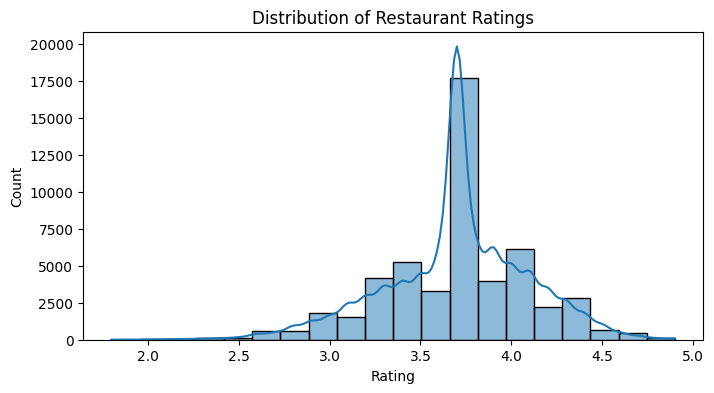

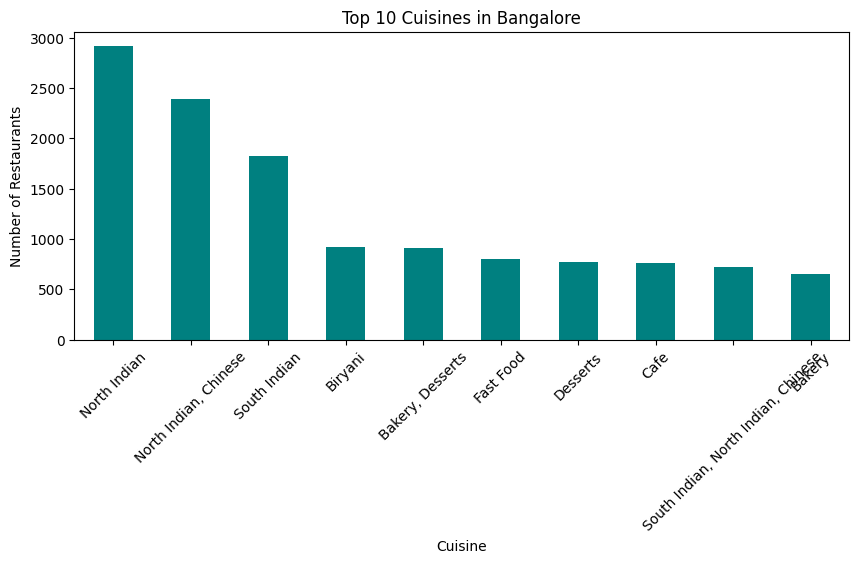

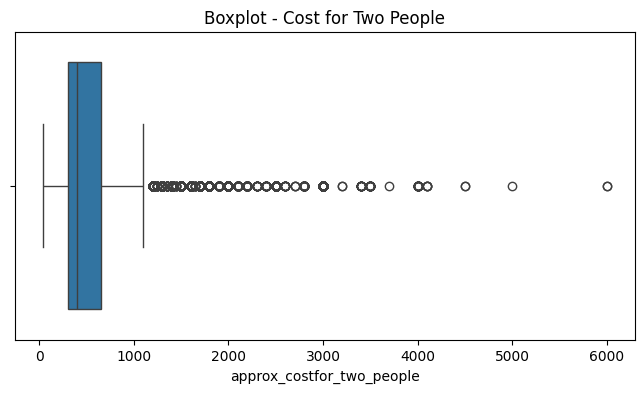

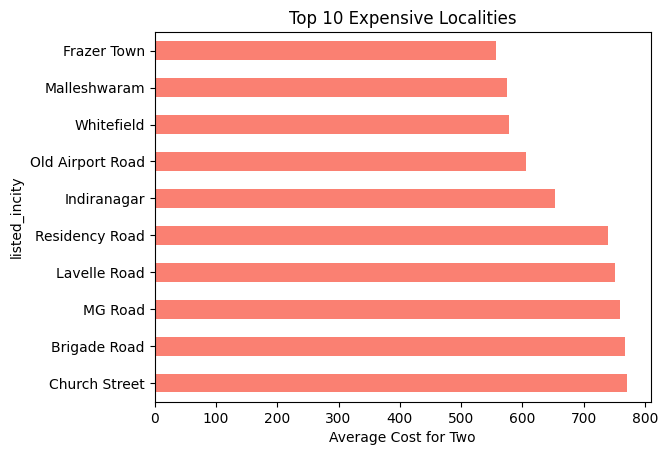

In [6]:
#EDA

# Rating Distribution
plt.figure(figsize=(8,4))
sns.histplot(cleaned_df['rate'], bins=20, kde=True)
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Top 10 Cuisines
plt.figure(figsize=(10,4))
cleaned_df['cuisines'].value_counts().head(10).plot(kind='bar', color='teal')
plt.title('Top 10 Cuisines in Bangalore')
plt.xlabel('Cuisine')
plt.ylabel('Number of Restaurants')
plt.xticks(rotation=45)
plt.show()

# Cost for Two Distribution
plt.figure(figsize=(8,4))
sns.boxplot(x=cleaned_df['approx_costfor_two_people'])
plt.title('Boxplot - Cost for Two People')
plt.show()

# Top Localities by Average Cost
top_localities = cleaned_df.groupby('listed_incity')['approx_costfor_two_people'].mean().sort_values(ascending=False).head(10)
top_localities.plot(kind='barh', color='salmon')
plt.title("Top 10 Expensive Localities")
plt.xlabel("Average Cost for Two")
plt.show()


In [12]:
#Task2
# Filter Italian restaurants
italian_df = merged_df[merged_df['cuisines'].str.contains("Italian", case=False, na=False)]

# Create Folium map centered on Bangalore
italian_map = folium.Map(location=[12.9716, 77.5946], zoom_start=12)

# Add purple markers for each Italian restaurant
for _, row in italian_df.iterrows():
    if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']):
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=f"{row['listed_incity']}<br>{row['cuisines']}",
            icon=folium.Icon(color='purple')
        ).add_to(italian_map)

# Save and display the map
italian_map.save("italian_restaurants_map.html")

#Show
display(IFrame("/content/italian_restaurants_map.html", width=750, height=500))


In [13]:
#Task3: Restaurant Density Mapping

#Initialize Folium map
density_map = folium.Map(location=[12.9716, 77.5946], zoom_start=12)

#Add marker cluster
marker_cluster = MarkerCluster().add_to(density_map)

#Loop through restaurants and add markers
for _, row in merged_df.iterrows():
    if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']):
        popup = (
            f"<b>City:</b> {row['listed_incity']}<br>"
            f"<b>Rating:</b> {row['rate']}<br>"
            f"<b>Cost for Two:</b> ₹{row['approx_costfor_two_people']}"
        )
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=popup
        ).add_to(marker_cluster)

#Save the map
density_map.save("/content/restaurant_density_map.html")

#Display the map in Colab
display(IFrame("/content/italian_restaurants_map.html", width=750, height=500))